# Graphs in SQL

This notebook gives an introduction to handling graphs in SQL. We assume basic knowledge of the SQL language and the [PostgreSQL](https://www.postgresql.org/) database. It is based on the [`psycopg2`](http://initd.org/psycopg/docs/) and the [`py2neo`](https://py2neo.org/v4/index.html) packages for python. 

Copyright Christian Schön & Jens Dittrich, [Big Data Analytics Group](https://bigdata.uni-saarland.de/), [CC-BY-SA](https://creativecommons.org/licenses/by-sa/4.0/legalcode)

## Setup - PostgreSQL

Before you can use the following notebook, you have to setup the databases: PostgreSQL in the beginning, Neo4j in the later sections.
The database stores different examples: The first example is a social network graph indicating which person knows, meets, or writes with which other person. The second example is a precedence graph with nine different transactions. Both examples have been presented on the corresponding lecture slides, although the precedence graph example will be extended for later sections of this notebook.

In [1]:
# Specify paths to CSV files for social network
contacts_persons_csv = "./data/cypher/contacts_persons.csv"
contacts_knows_csv = "./data/cypher/contacts_knows.csv"
contacts_meets_csv = "./data/cypher/contacts_meets.csv"
contacts_writes_csv = "./data/cypher/contacts_writes.csv"

# Specify paths to CSV files for precedence graph
transactions_nodes_csv = "./data/cypher/transactions_nodes.csv"
transactions_precedence_csv = "./data/cypher/transactions_precedence.csv"

### Postgres

Inside our database, we create several new tables to store the necessary data for our examples:
* The `persons` table with attributes `node_id` and `name` for the social network graph
* The `knows` table with attributes `start_id` and `end_id` for the social network graph
* The `meets` table with attributes `start_id` and `end_id` for the social network graph
* The `writes` table with attributes `start_id` and `end_id` for the social network graph
* The `nodes` table with attributes `node_id`and `name` for the precedence graph
* The `edges` table with attributes `start_id`and `end_id` for the precedence graph

In [3]:
import psycopg2
import csv

# Import functions used to draw results in later sections
from vis.vis import drawSubgraph, print_set_postgres, print_set_neo4j

# Specify credentials
dsn = "dbname=postgres user=postgres host=/var/run/postgresql/"

# Create a connection to the database and open a cursor to execute queries
conn = psycopg2.connect(dsn)
conn.autocommit = True

In [4]:
# Social network graph

# Create table persons and fill with corresponding values
cur = conn.cursor()
cur.execute("DROP TABLE IF EXISTS persons CASCADE;")
cur.execute("CREATE TABLE persons (node_id INTEGER PRIMARY KEY, name CHARACTER VARYING(3) NOT NULL);")
with open(contacts_persons_csv, newline='') as csvfile:
    csvreader = csv.DictReader(csvfile)
    for row in csvreader:
        cur.execute("INSERT INTO persons(node_id, name) VALUES({}, '{}');".format(int(row['node_id']), str(row['name'])))
cur.close()

# Create tables 'knows', 'meets' and 'writes'; and fill them with corresponding values
for entitytype in ['knows','meets','writes']:
    cur = conn.cursor()
    cur.execute("DROP TABLE IF EXISTS " + entitytype + " CASCADE;")
    cur.execute("CREATE TABLE " + entitytype + " (start_id INTEGER, end_id INTEGER, PRIMARY KEY(start_id, end_id));")
    with open(contacts_knows_csv, newline='') as csvfile:
        csvreader = csv.DictReader(csvfile)
        for row in csvreader:
            cur.execute("INSERT INTO " + entitytype + "(start_id, end_id) VALUES({}, '{}');".format(int(row['start_id']), int(row['end_id'])))
    cur.close()

In [5]:
# Precedence graph

# Create table nodes and fill with corresponding values
cur = conn.cursor()
cur.execute("DROP TABLE IF EXISTS nodes CASCADE;")
cur.execute("CREATE TABLE nodes (node_id INTEGER PRIMARY KEY, name CHARACTER VARYING(3) NOT NULL);")
with open(contacts_persons_csv, newline='') as csvfile:
    csvreader = csv.DictReader(csvfile)
    for row in csvreader:
        cur.execute("INSERT INTO nodes(node_id, name) VALUES({}, '{}');".format(int(row['node_id']), str(row['name'])))
cur.close()

# Create view nodes_small for the smaller example
cur = conn.cursor()
cur.execute("DROP VIEW IF EXISTS nodes_small;")
cur.execute("CREATE VIEW nodes_small AS SELECT * FROM nodes WHERE nodes.node_id <= 3;")
cur.close()

# Create table edges
cur = conn.cursor()
cur.execute("DROP TABLE IF EXISTS edges CASCADE;")
cur.execute("CREATE TABLE edges (start_id INTEGER, end_id INTEGER, PRIMARY KEY(start_id, end_id));")
with open(transactions_precedence_csv, newline='') as csvfile:
    csvreader = csv.DictReader(csvfile)
    for row in csvreader:
        cur.execute("INSERT INTO edges(start_id, end_id) VALUES({}, '{}');".format(int(row['start_id']), int(row['end_id'])))
cur.close()

# Create view edges_small for the smaller example
cur = conn.cursor()
cur.execute("DROP VIEW IF EXISTS edges_small;")
cur.execute("CREATE VIEW edges_small AS SELECT * FROM edges WHERE edges.start_id <= 3 AND edges.end_id <= 3;")
cur.close()

## Social Network Graph - SQL

Our first example is the social network graph, consisting of four persons in total which might know, meet, or write with another person in the network.

### Simple Queries - SQL

To check if the PostgreSQL database is setup correctly, we can simply query the list of nodes stored in the database. The result should consist of four persons with IDs 0 to 4 and names 'A' to 'D'.

In [6]:
# PostgreSQL
cur = conn.cursor()
cur.execute("""
SELECT *
FROM persons
ORDER BY node_id;
""")
print_set_postgres(cur)
cur.close()

[Result] : {[ node_id, name ]}
{
	(0, A),
	(1, B),
	(2, D),
	(3, C)
}


We can also query which person knows which other person:

In [7]:
# PostgreSQL
cur = conn.cursor()
cur.execute("""
SELECT pStart.name AS "pStart.name", pEnd.name AS "pEnd.name"
FROM knows 
    JOIN persons AS pStart ON knows.start_id = pStart.node_id
    JOIN persons AS pEnd ON knows.end_id = pEnd.node_id;
""")
print_set_postgres(cur)
cur.close()

[Result] : {[ pStart.name, pEnd.name ]}
{
	(A, B),
	(A, C)
}


## Recursive Queries in SQL

Besides the basic language features presented in earlier lectures and notebooks, SQL offers also some more advanced language features that allow us to simplify some queries. The [`WITH RECURSIVE`](https://www.postgresql.org/docs/current/queries-with.html) statement defines a recursive subquery which can be reused inside its own body. The use of [`ARRAYS`](https://www.postgresql.org/docs/current/arrays.html) allows us to work with lists of values in PostgreSQL.

### Recursive Queries

The following query demonstrates the use of recursive queries and outputs the sum of all integers between 1 and 100. It first defines a recursive subquery `t` with the argument `n` which can then be reused in the body of the query (in parentheses following the `AS`). This body first defines a base case for the recursion, setting the argument `n` to the constant value 1. It then appends `n+1` to `t` using `UNION ALL`in each recursive step as long as `n` is smaller than 100. The outer query at the end then simply outputs the sum of all `n` contained in `t`.

In [8]:
cur = conn.cursor()
cur.execute("""
WITH RECURSIVE foo(n) AS (
     VALUES (1)
  UNION 
     SELECT n+1 FROM foo WHERE n < 3
)
SELECT * FROM foo;
""")
print_set_postgres(cur)
cur.close()

[Result] : {[ n ]}
{
	(1),
	(2),
	(3)
}


In [9]:
cur = conn.cursor()
cur.execute("""
WITH RECURSIVE foo(n) AS (
     VALUES (1),(2),(3)
  UNION ALL
     SELECT n+1 FROM foo
     WHERE n < 3
)
SELECT * FROM foo;
""")
print_set_postgres(cur)
cur.close()

[Result] : {[ n ]}
{
	(1),
	(2),
	(3),
	(2),
	(3),
	(3)
}


### Arrays

An array in the context of SQL is simply a list of values than can be stored in a database. PostgreSQL uses the `ARRAY` command to generate such an array. An array `arr` can be modified with a Python-like syntax: `arr[1] = 1` assigns the value 1 to the first element of the array. `arr[2:4] = {2,3,4}` assigns new values to the second to fourth element. Pay attention: The index is one-based, not zero-based as in most programming languages. The `||` operator allows to append new elements to the array: `ARRAY[1,2] || ARRAY[3,4]` generates a new array containing the values 1 to 4. The following query demonstrates the use of arrays and outputs a list of arrays, starting with an array containing just the value 1 and appending the next integer in each recursive step. The terminating condition for the recursion is implemented using the `ANY` operator which checks if any value in the array is greater or equal 10.

In [9]:
cur = conn.cursor()
cur.execute("""
WITH RECURSIVE t(n, arr) AS (
    VALUES(1, ARRAY[1])
  UNION ALL
    SELECT n+1, arr || n+1 FROM t WHERE NOT 10 <= ANY(arr)
)
SELECT * FROM t;
""")
print_set_postgres(cur)
cur.close()

[Result] : {[ n, arr ]}
{
	(1, [1]),
	(2, [1, 2]),
	(3, [1, 2, 3]),
	(4, [1, 2, 3, 4]),
	(5, [1, 2, 3, 4, 5]),
	(6, [1, 2, 3, 4, 5, 6]),
	(7, [1, 2, 3, 4, 5, 6, 7]),
	(8, [1, 2, 3, 4, 5, 6, 7, 8]),
	(9, [1, 2, 3, 4, 5, 6, 7, 8, 9]),
	(10, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
}


## Basic Precedence Graph (SQL)

We now move on to the basic transaction graph example presented in the lecture slides, consisting of just 3 transactions.
We will first search for cycles in this small graph before moving on to a more complex example.
Obviously, we shouldn't find any cycles in this example.

### Visualize the Graph

We first visualize the graph:

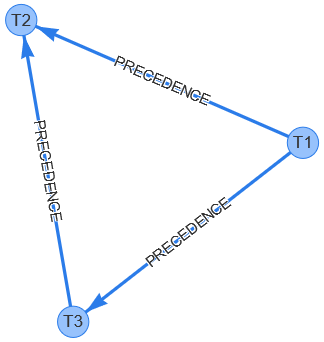

In [10]:
from IPython.display import Image
Image(filename='pics/graphs/basic_example.png') 

### SQL (Naive Way)

A naive approach to find cycles is to simply join the `edges` table multiple times with itself to find all paths contained in the graph. We can then detect cycles by comparing the start nodes with the end nodes. In other words, we iteratively expand edges to paths.

In [11]:
cur = conn.cursor()
cur.execute("""
SELECT * 
FROM edges_small AS e1 
LEFT OUTER JOIN edges_small AS e2 ON e1.end_id = e2.start_id AND e1.start_id != e2.start_id
""")
print_set_postgres(cur)
cur.close()

[Result] : {[ start_id, end_id, start_id, end_id ]}
{
	(1, 2, None, None),
	(1, 3, 3, 2),
	(3, 2, None, None)
}


Only for edge (1,3) we found a join mate.

In [12]:
cur = conn.cursor()
cur.execute("""
SELECT e1.start_id, e1.end_id, e2.end_id, e3.end_id
FROM edges_small AS e1 
LEFT OUTER JOIN edges_small AS e2 ON e1.end_id = e2.start_id AND e1.start_id != e2.start_id
LEFT OUTER JOIN edges_small AS e3 ON e2.end_id = e3.start_id AND e1.start_id != e3.start_id;
""")
print_set_postgres(cur)
cur.close()

[Result] : {[ start_id, end_id, end_id, end_id ]}
{
	(1, 2, None, None),
	(1, 3, 2, None),
	(3, 2, None, None)
}


As there is no outgoing edge from node 2, (None, None) is added to the path.

So, let's filter out all result tuples that end at our initial node:

In [13]:
cur = conn.cursor()
cur.execute("""
SELECT e1.start_id, e1.end_id, e2.end_id, e3.end_id 
FROM edges_small AS e1 
LEFT OUTER JOIN edges_small AS e2 ON e1.end_id = e2.start_id AND e1.start_id != e2.start_id
LEFT OUTER JOIN edges_small AS e3 ON e2.end_id = e3.start_id AND e1.start_id != e3.start_id
WHERE e1.end_id = e1.start_id -- cycle through a self-reference
    OR e2.end_id = e1.start_id -- cycle through one other node than e1
    OR e3.end_id = e1.start_id -- cycle through two other nodes than e1
ORDER BY e1.start_id, e1.end_id, e2.end_id, e3.end_id;
""")
print_set_postgres(cur)
cur.close()

[Result] : {[ start_id, end_id, end_id, end_id ]}
{
}


The result set is empty, hence there are no cycles in this graph.

## Advanced Precedence Graph (SQL)

In the following, we will extend the basic example from the lecture slides to a total of nine transactions containing multiple possible cycles.

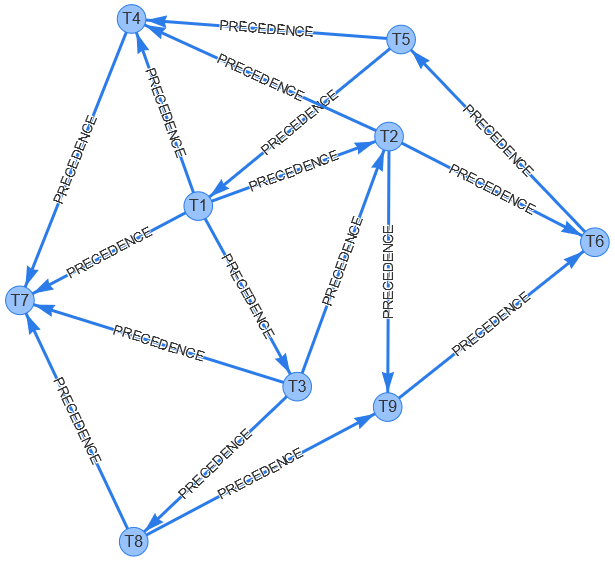

In [14]:
from IPython.display import Image
Image(filename='pics/graphs/advanced_example.png') 

### SQL (Naive Way)

Of course, we could again use the naive way to compute possible cycles. However, the query becomes pretty large and would grow even further if the number of nodes increases:

In [15]:
# show all possible paths through the graph up to length 9:
cur = conn.cursor()
cur.execute("""
SELECT e1.start_id, e1.end_id, e2.end_id, e3.end_id, e4.end_id, e5.end_id, e6.end_id, e7.end_id, e8.end_id, e9.end_id
FROM edges AS e1 
LEFT OUTER JOIN edges AS e2 ON e1.end_id = e2.start_id AND e1.start_id != e2.start_id
LEFT OUTER JOIN edges AS e3 ON e2.end_id = e3.start_id AND e1.start_id != e3.start_id
LEFT OUTER JOIN edges AS e4 ON e3.end_id = e4.start_id AND e1.start_id != e4.start_id
LEFT OUTER JOIN edges AS e5 ON e4.end_id = e5.start_id AND e1.start_id != e5.start_id
LEFT OUTER JOIN edges AS e6 ON e5.end_id = e6.start_id AND e1.start_id != e6.start_id
LEFT OUTER JOIN edges AS e7 ON e6.end_id = e7.start_id AND e1.start_id != e7.start_id
LEFT OUTER JOIN edges AS e8 ON e7.end_id = e8.start_id AND e1.start_id != e8.start_id
LEFT OUTER JOIN edges AS e9 ON e8.end_id = e9.start_id AND e1.start_id != e9.start_id
ORDER BY e1.start_id, e1.end_id, e2.end_id, e3.end_id, e4.end_id, e5.end_id, e6.end_id, e7.end_id, e8.end_id, e9.end_id;
""")
print_set_postgres(cur)
cur.close()

[Result] : {[ start_id, end_id, end_id, end_id, end_id, end_id, end_id, end_id, end_id, end_id ]}
{
	(1, 2, 4, 7, None, None, None, None, None, None),
	(1, 2, 6, 5, 1, None, None, None, None, None),
	(1, 2, 6, 5, 4, 7, None, None, None, None),
	(1, 2, 9, 6, 5, 1, None, None, None, None),
	(1, 2, 9, 6, 5, 4, 7, None, None, None),
	(1, 3, 2, 4, 7, None, None, None, None, None),
	(1, 3, 2, 6, 5, 1, None, None, None, None),
	(1, 3, 2, 6, 5, 4, 7, None, None, None),
	(1, 3, 2, 9, 6, 5, 1, None, None, None),
	(1, 3, 2, 9, 6, 5, 4, 7, None, None),
	(1, 3, 7, None, None, None, None, None, None, None),
	(1, 3, 8, 7, None, None, None, None, None, None),
	(1, 3, 8, 9, 6, 5, 1, None, None, None),
	(1, 3, 8, 9, 6, 5, 4, 7, None, None),
	(1, 4, 7, None, None, None, None, None, None, None),
	(1, 7, None, None, None, None, None, None, None, None),
	(2, 4, 7, None, None, None, None, None, None, None),
	(2, 6, 5, 1, 2, None, None, None, None, None),
	(2, 6, 5, 1, 3, 2, None, None, None, None),
	(2, 6, 5

In [16]:
# show all possible paths through the graph up to length 9 that end up at the start node, i.e. a cycle:
cur = conn.cursor()
cur.execute("""
SELECT e1.start_id, e1.end_id, e2.end_id, e3.end_id, e4.end_id, e5.end_id, e6.end_id, e7.end_id, e8.end_id, e9.end_id
FROM edges AS e1 
LEFT OUTER JOIN edges AS e2 ON e1.end_id = e2.start_id AND e1.start_id != e2.start_id
LEFT OUTER JOIN edges AS e3 ON e2.end_id = e3.start_id AND e1.start_id != e3.start_id
LEFT OUTER JOIN edges AS e4 ON e3.end_id = e4.start_id AND e1.start_id != e4.start_id
LEFT OUTER JOIN edges AS e5 ON e4.end_id = e5.start_id AND e1.start_id != e5.start_id
LEFT OUTER JOIN edges AS e6 ON e5.end_id = e6.start_id AND e1.start_id != e6.start_id
LEFT OUTER JOIN edges AS e7 ON e6.end_id = e7.start_id AND e1.start_id != e7.start_id
LEFT OUTER JOIN edges AS e8 ON e7.end_id = e8.start_id AND e1.start_id != e8.start_id
LEFT OUTER JOIN edges AS e9 ON e8.end_id = e9.start_id AND e1.start_id != e9.start_id
WHERE e1.end_id = e1.start_id -- cycle through a self-reference
    OR e2.end_id = e1.start_id -- cycle through one other node than e1
    OR e3.end_id = e1.start_id -- cycle through two other nodes than e1
    OR e4.end_id = e1.start_id -- ...
    OR e5.end_id = e1.start_id
    OR e6.end_id = e1.start_id
    OR e7.end_id = e1.start_id
    OR e8.end_id = e1.start_id
    OR e9.end_id = e1.start_id 
ORDER BY e1.start_id, e1.end_id, e2.end_id, e3.end_id, e4.end_id, e5.end_id, e6.end_id, e7.end_id, e8.end_id, e9.end_id;
""")
print_set_postgres(cur)
cur.close()

[Result] : {[ start_id, end_id, end_id, end_id, end_id, end_id, end_id, end_id, end_id, end_id ]}
{
	(1, 2, 6, 5, 1, None, None, None, None, None),
	(1, 2, 9, 6, 5, 1, None, None, None, None),
	(1, 3, 2, 6, 5, 1, None, None, None, None),
	(1, 3, 2, 9, 6, 5, 1, None, None, None),
	(1, 3, 8, 9, 6, 5, 1, None, None, None),
	(2, 6, 5, 1, 2, None, None, None, None, None),
	(2, 6, 5, 1, 3, 2, None, None, None, None),
	(2, 9, 6, 5, 1, 2, None, None, None, None),
	(2, 9, 6, 5, 1, 3, 2, None, None, None),
	(3, 2, 6, 5, 1, 2, 6, 5, 1, 3),
	(3, 2, 6, 5, 1, 3, None, None, None, None),
	(3, 2, 9, 6, 5, 1, 3, None, None, None),
	(3, 8, 9, 6, 5, 1, 3, None, None, None),
	(5, 1, 2, 6, 5, None, None, None, None, None),
	(5, 1, 2, 9, 6, 5, None, None, None, None),
	(5, 1, 3, 2, 6, 5, None, None, None, None),
	(5, 1, 3, 2, 9, 6, 5, None, None, None),
	(5, 1, 3, 8, 9, 6, 5, None, None, None),
	(6, 5, 1, 2, 6, None, None, None, None, None),
	(6, 5, 1, 2, 9, 6, None, None, None, None),
	(6, 5, 1, 3, 2, 6, N

### SQL (Using Recursive Query)

We can simplify the above query if we use the advanced language feature "recursive queries" which we introduced in earlier sections of this notebook.
However, we must combine the language features introduced above to a pretty complex query. It defines a recursive query `rec_edges` which stores the following arguments:
* `start_id`: The id of the node the current edge is starting at
* `end_id`: The id of the node the current edge is ending at
* `length`: The length of the path already explored
* `path`: The path we already explored, stored as an array
* `cycle`: A boolean value indicating if we found a cycle in our path

In our base case, we initialize an array containing the `start_id` of each edge, set the length to 1 and the boolean flag `cycle` to false. In the recursive step, we then recursively join our previous paths with the edges relation (as we have done in the naive approach using the `LEFT OUTER JOIN`). We increase the `length` parameter of the result by 1 and append the id of the start node of the newly joined edge to the `path`. The `cycle` argument is updated by checking if any value in the `path` is equal to the id of the current start node. We continue this recursive step as long as we haven't found a cycle.

We finally output the id of the first node in our path (where we started our exploration), the length of the cycle found and the array containing all node ids within the cycle. We restrict our output to cycles beginning with the first node (i.e. the path contains no node prior to the cycle).

In [17]:
cur = conn.cursor()
cur.execute("""
-- create a local view with the following attributes:
-- start node, end node, length of the path, the path-array, and whether cycle
WITH RECURSIVE rec_edges(start_id, end_id, length, path, cycle) AS (
        -- return all edges and their start and end nodes 
        -- expand each tuple by the length of the path (1), the path (start_id) and 
        -- whether we found a cycle (false unless the edge is a self-reference, not present in the example data)
        SELECT e.start_id, e.end_id, 1, ARRAY[e.start_id], e.start_id = e.end_id
        FROM edges AS e
    UNION
        -- join next edge to temporary result,
        -- increase path length by one,
        -- append current node to path-array (using the ||-operator),
        -- additionaly check if e.start_id can be found in the path-array (using ANY(); if true, we found a cycle)
        SELECT e.start_id, e.end_id, re.length + 1, path || e.start_id, e.start_id = ANY(path)
        FROM edges AS e JOIN rec_edges AS re ON e.start_id = re.end_id
        WHERE NOT cycle
        -- we only consider paths that do not contain a cycle yet
        -- this works as each result of a recursive part of WITH RECURSIVE is added to the total result anayways!
)
-- pick all paths that are cycles (in the sense that we return to the start node)
SELECT DISTINCT start_id, length, path
FROM rec_edges
WHERE cycle AND start_id = path[1];
""")
print_set_postgres(cur)
cur.close()

[Result] : {[ start_id, length, path ]}
{
	(1, 5, [1, 2, 6, 5, 1]),
	(1, 6, [1, 2, 9, 6, 5, 1]),
	(1, 6, [1, 3, 2, 6, 5, 1]),
	(1, 7, [1, 3, 2, 9, 6, 5, 1]),
	(1, 7, [1, 3, 8, 9, 6, 5, 1]),
	(2, 5, [2, 6, 5, 1, 2]),
	(2, 6, [2, 6, 5, 1, 3, 2]),
	(2, 6, [2, 9, 6, 5, 1, 2]),
	(2, 7, [2, 9, 6, 5, 1, 3, 2]),
	(3, 6, [3, 2, 6, 5, 1, 3]),
	(3, 7, [3, 2, 9, 6, 5, 1, 3]),
	(3, 7, [3, 8, 9, 6, 5, 1, 3]),
	(5, 5, [5, 1, 2, 6, 5]),
	(5, 6, [5, 1, 2, 9, 6, 5]),
	(5, 6, [5, 1, 3, 2, 6, 5]),
	(5, 7, [5, 1, 3, 2, 9, 6, 5]),
	(5, 7, [5, 1, 3, 8, 9, 6, 5]),
	(6, 5, [6, 5, 1, 2, 6]),
	(6, 6, [6, 5, 1, 2, 9, 6]),
	(6, 6, [6, 5, 1, 3, 2, 6]),
	(6, 7, [6, 5, 1, 3, 2, 9, 6]),
	(6, 7, [6, 5, 1, 3, 8, 9, 6]),
	(8, 7, [8, 9, 6, 5, 1, 3, 8]),
	(9, 6, [9, 6, 5, 1, 2, 9]),
	(9, 7, [9, 6, 5, 1, 3, 2, 9]),
	(9, 7, [9, 6, 5, 1, 3, 8, 9])
}
